# Resonance Elastic Scattering of $\alpha$-particles with ${}^{10}\text{C}$

In [38]:
import json
import pickle
from pathlib import Path

import awkward as ak
import hist
import numpy as np
from matplotlib import pyplot as plt

The GET acquisition system serialises data using the MultiFrame Metaformat (MFM)
> a binary format for data acquisition and serialization that are self-contained, layered, adapted to network transfers[,] and evolving. {cite:ps}`anvar_multiframe_nodate`

This file format is more suitable for disk storage than in-memory representation of data, as it is a heirarchical format in which each _frame_ must be read, regardless of whether it is needed. The use of separate header and data sections means that the cost of skipping a frame is limited to parsing the header, but MFM is still a struct-based format. In many cases, columnar processing is both more performant and more expressive than an equivalent event-loop based approach.{cite:ps}`smith_case_2019` 

The analysis process was performed in a series of discrete stages (see {numref}`analysis-flowchart`).

<!-- :::{figure-md} analysis-flowchart -->

:::{mermaid}
flowchart LR

signal --> calibrate[Silicon Calibration*]
baseline_removal --> gain_matching[Gain Matching*]
baseline_removal --> response[Response Estimation*]
gain_matching --> signal
calibrate --> kinematic_fitting
response --> signal

get[/GET MFM/] --> mfm2root[ROOT Conversion] --> partitioning[Partitioning] --> noise_removal[Noise Removal] --> baseline_removal[Baseline Removal] --> signal[Signal Fitting] --> event[Cluster Reconstruction] --> fit[Track Fitting] --> kinematic_fitting[Kinematic Fitting] --> kinematics[/Kinematics/]

gas_parameters[/Gas Parameters/] --> gas_simulation[Garfield++ Simulation] --> event

:::

<!-- The asterisk \* indicates processes which were aggregated over the entire dataset ahead of reconstruction -->
<!-- ::: -->

```{warning}
TODO: 
- [ ] make this wrap nicely
- [ ] support hyperlinks to sections in this figure
```

## Partitioning
At the earliest stages of the reconstruction pipeline, performance is primarily bounded by available memory, and therefore it is sensible to partition the data by event multiplicity. This process constitutes the first two stages of this analysis, seen in {numref}`analysis-flowchart`. In the ROOT dataset, the `mmMul` branch contains the per-event multiplicity. To regularise the dataset according to this multiplicity, it was partitioned into approximate chunks of a given aggregate multiplicity. Given that the memory of an MFM event is primarily determined by the number of waveforms that it contains, this effectively balances the memory footprint of each partition.

In subsequent stages, the memory bound gives way to compute costs, and so the partition size is refined to balance naive parallelisation against parallisation overhead. Where data is written to disk, the Hierarchical Data Format version 5 (HDF5) format is used as a consequence of its good language support, high compression ratios (with GZip), and columnar representation.{cite:ps}`the_hdf5_group_hierarchical_1997` The Parquet format is another strong format for columnar representation but, due to some library constraints, HDF5 was preferred.

## Noise and Baseline Removal

As discussed in {ref}`content:get-architecture`, the AGET chip provides four additional channels for measuring the electronic noise. These channels can be used to eliminate some of the electronic noise inherent within the system. A number of noise removal strategies are discussed in {cite:ps}`giovinazzo_get_2016-1`, and establishes that an average over the set of FPN channels per-chip is optimal. It was this strategy that was employed to for noise removal (see {numref}`fpn-removal-micromegas`).


:::{figure} todo
:name: fpn-removal-micromegas
:width: 400px
:align: center

```{warning}
Todo: add example of FPN channel & FPN removal
```
:::

In addition to a low frequency component of the electronic noise, a separate baseline offset was observed in the MicroMeGAS and silicon detector channels. This component was removed using two separate methods:

### MicroMeGaS Baseline Estimation

Given that time in the MicroMeGaS is primarly determined by the drift time of the liberated electrons in the gas volume, the baseline observed in the MicroMeGaS detector was not seen to occur at specific times. Therefore, in order to identify the region of baseline that would be linearly subtracted from the recorded signal, a local variance was computed for the channel samples, with a window of 96 cells (see {numref}`baseline-estimate-micromegas`).

:::{figure} todo
:name: baseline-estimate-micromegas
:width: 400px
:align: center

```{warning}
Todo: add example of baseline estimation
```
:::


The value of the baseline was given by the locus of the minimum computed variance.

### Silicon Baseline Estimation

Unlike the MicroMeGaS channels, the silicon quadrant detectors have a well defined boundary between the baseline and the interaction signals. This boundary occurs at a similar time for each detector, as it is the silicon detectors upon which the GET system was configured to trigger. To determine the baseline value, the mean of the sample values for the preceeding ten cells was used (see {numref}`baseline-estimate-silicon`).

:::{figure} todo
:name: baseline-estimate-silicon
:width: 400px
:align: center

```{warning}
Todo: add example of baseline estimation
```
:::

## Response Estimation

Channels which employ the AGET shaper require deconvolution in order to recover the underlying signal. This process requires a good knowledge of the underlying response function of the system. An approximate analytical solution is given in {cite:ps}`giovinazzo_get_2016-1`, but the authors note that it is insufficiently accurate to be used with deconvolutional methods. It is noted that the electronics can be configured such that the response function can be directly measured, but this required secondary access to the detector which resides at the Cyclotron Institute, Texas A&M University.{cite:ps}`giovinazzo_get_2016-1` 

### Iterative Estimation
In order to determine a better approximation for the response function, an iterative deconvolve-fit process can be applied to a set of MicroMeGaS waveforms. These waveforms should be taken from a random spanning sample of the recorded MicroMeGaS waveforms (see {numref}`mm-random-sample`). 

:::{figure} image/placeholder/mm-response-precursor.png
---
name: mm-random-sample
alt: A plot of the waveforms that are used by the fitting process to derive an estimated response function.
width: 400px
align: center
---
A plot of the waveforms that are employed by the fitting process to derive an estimated response function.
:::

Given such a sample, an initial estimate of the response function $F^{(1)}$ can be used to fit each waveform with the convolution of a Gaussian function 

:::{math}
:label: iterative-estimate
Y^{(1)} = F^{(1)} * \mathcal{N}^{(1)}\,.
:::

The resulting fit $\mathcal{N}^{(1)}$ can then be _deconvolved_ from the original sample $Y$ to produce of $F^{(2)}$. This process can be repeated until the solution becomes stable, and the solutions for a set of random waveforms may be averaged to produce a singular response function $F$ (see {numref}`mm-response-vs-get`).

:::{figure} image/placeholder/mm-response-iteration.png
---
name: mm-response-vs-get
alt: A plot of the estimated response function over several iterations. The response function becomes broader with each iteration.
width: 400px
align: center
---
A plot of the estimated response function over several iterations. It can be seen that the estimated response function becomes broader with each iteration.
:::

Given that the convolution of any two Gaussians is also Gaussian, the solution from {eq}`iterative-estimate` is not guaranteed to be unique, i.e. the resulting response function may include some Gaussian component. This can be seen when the estimated response function is compared with any one silicon sample: the silicon sample is on average slightly narrower than that of the estimated response function (see {numref}`mm-vs-si-sample`).

:::{figure} image/placeholder/response-si-vs-mm.png
---
name: mm-vs-si-sample
alt: A comparison of the response functions estimated with MicroMeGaS waveforms and silicon waveforms. Both waveforms look similar, though the MicroMeGaS waveform is noticeably broader
width: 400px
align: center
---
A comparison of the response functions estimated with MicroMeGaS waveforms and silicon waveforms.
:::

Applying a convolution to the silicon response function with a fixed-with Gaussian brings the two estimates into closer agreement (see {numref}`mm-vs-si-sample-broad`)
:::{figure} image/placeholder/response-si-vs-mm-broad.png
---
name: mm-vs-si-sample-broad
alt: A comparison of the response functions estimated with MicroMeGaS waveforms and silicon waveforms, following broadening. Both waveforms look similar, with only minor disagreement at the edges of the two samples.
width: 400px
align: center
---
A comparison of the response functions estimated with MicroMeGaS waveforms and silicon waveforms, following Gaussian broadening of the silicon response.
:::

### Sample Averaging

It follows that the silicon waveforms may provide a more robust mechanism for estimating the response function. If one assumes that that the shape of the current signal produced by interactions with the silicon detector is predominantly determined by the shaper, then the measured signal is to first approximation simply a convolution of the intrinsic response function and some normal component $F' * \mathcal{N}$. 

To build a response function estimate, a random sample of silicon waveforms spanning a range of amplitudes is taken. The binwise mean of this set of waveforms is taken to produce an average waveform (see {numref}`si-response-average`). This waveform is an approximate response function, which can then be time-shifted such that the peak coincides with $t=0$.


:::{figure} image/placeholder/si-response-average.png
---
name: si-response-average
alt: A plot of the waveforms that are averaged to compute the silicon response function.
width: 400px
align: center
---
A plot of the silicon waveforms prior to averaging.
:::


## Gain Matching

In {ref}`content:micromegas`, it was noted that the MicroMeGaS anode is subdivided into a set of distinct zones that can be held at different potentials in order to spatially vary the gain. In this experiment, both the strip-chain (side) regions and final block of pads in the central region were held at a high gain in order to better resolve light particle tracks with low stopping powers (see {numref}`micromegas-anode-gain-region`). 

:::{figure} todo
:name: micromegas-anode-gain-region
:::

:::{note}
TODO: add an image of micromegas-anode-gain-region
:::

Following position reconstruction, these gains must be accounted for if the collected charge is to be used for particle identification. Given that the strips, chains, and final central pads were held at the same potential, the relative gain of these regions can be determined solely by looking at the relative gain of the final central pad region. This was experimentally measured by observing the change in charge collected by the rows of pads either side of the high-low gain boundary.


:::{figure} image/placeholder/gain-high-dark.png
---
alt: Ratio of low gain and high gain mean charge at the gain boundary.
width: 400px
align: center
---
Ratio of the mean collected charge between the low gain and high gain region boundary in the Micromegas pads.
:::

In [6]:
# Load the relative gain
relative_gain = json.loads((Path("data") / "relative-gain.json").read_text())
relative_gain_3f = f"{relative_gain:.3f}"

After fitting this distribution with a binned likelihood estimator, the relative gain between the high and low gain regions was found to be {eval}`relative_gain_3f`.

(signal-fitting)=
## Signal Fitting

In the above sections, it was established that the sampled GET waveforms are effectively convolutions of an original source signal and the intrinsic GET shaper response function. Having determined an approximation for this response function, the source signals can then be recovered by deconvolutional methods. 

For each preprocessed sample, a convolutional Gaussian fit is performed that solves $y = F * \mathcal{N}(\boldsymbol{\phi})$ for $\boldsymbol{\phi}$. This is preferred over computing the Gaussian fit of the deconvolved signal; although repeated convolution is computationally expensive, it is less vulnerable to artefacts produced by the deconvolution technique. For samples which do not exceed the dynamic range of the acquisition system, the peak multiplicity is estimated using the GOLD deconvolution algorithm with boosting, which collapses broad peaks into smooth, sharp peaks. These peaks are then identified using a simple turning-point localiser, which is used to seed the initial fit parameters (see {numref}`turning-point-localiser`). 

:::{figure} todo
:name: turning-point-localiser
:::

:::{warning}
Figure show turning point localiser
:::

In some cases, the measured sample exceeds the maximum value that can be measured. This saturation introduces a discontinuity in the derivative of the sample, which renders it un-amenable to deconvolution (see {numref}`signal-saturation-discontinuity`).
:::{figure} todo
:name: signal-saturation-discontinuity
:::

:::{warning}
Figure show signal-saturation-discontinuity
:::

In such instances, one cannot easily determine the peak multiplicity of the sample. It is therefore assumed that the measured sample contains only one peak, which is fit as described above using an additional mask that forces the fit algorithm to reject the saturated regions.


:::{warning}
TODO: 
- [ ] discuss current vs voltage here of preamplifier
- [ ] check whether drift of charges is significant to signal formation in presence of micromesh?
- [ ] consider meaning of non linear least squares
:::

## Signal Ringing

In the presence of shaped signals whose amplitudes exceed the dynamic range of the ADC, spurious waveforms are observed in the other channels of the acquisition system. This phenomenon, known as "ringing", presents a challenge to the reconstruction of particle trajectories within the TPC. An example waveform is shown in {numref}`ringing-waveform`.

:::{figure} image/placeholder/ringing-waveform.png
---
name: ringing-waveform
alt: A waveform containing two distinct regions, one comprises a "ringing" waveform which exhibits multiple peaks with a poor shape, another with a single, well-defined, GET-shaped peak.
width: 400px
align: center
---
A waveform with the ringing phenomenon visible at $t\sim 320$. A distinct non-ringing component is also visible at $t\sim 410$.
:::

In order to identify and eliminate these spurious signals, one approach might be to consider the narrow width of the primary peaks. On average, it can be seen that ringing waveforms posses sharper peaks than true waveforms (see {numref}`ringing-width-distribution`)

:::{figure} image/placeholder/ringing-width-distribution.png
---
name: ringing-width-distribution
alt: A projection showing the distribution of the peak width for events with ringing and events without ringing.
width: 400px
align: center
---
The distribution of peak widths for ringing and non-ringing events.
:::

However, given that the shape of these ringing waveforms is not that of a typical GET waveform (see {numref}`ringing-waveform`), it follows that we cannot rely on the fit as a robust description of the ringing peak. In order to identify and remove these waveforms, a different approach must be taken.

As outlined above, the appearance of ringing waveforms in the sampled GET waveforms follows from the presence of saturated channels. Predictably, these ringing waveforms also occur at a similar time to that of these saturated signals (see {numref}`ringing-width-distribution`)

:::{figure} image/placeholder/saturated-waveform.png
---
name: saturated-waveform
alt: A waveform containing a single peak with a saturated maximum.
width: 400px
align: center
---
A waveform from the same event as {numref}`ringing-waveform` in which the signal is saturated at $t\sim 320$
:::

Consequently, the loci of peaks fit to saturated waveforms can be used to define a set of time intervals in which ringing signals may be anticipated. Given that one cannot use the GET fit to perform a robust classification between a measurement and a ringing signal, the amplitude of the signal may be used instead. It is observed that the majority of ringing signals have amplitudes well below that of the saturated signal, on the order of $y \lt 750$. By taking the logical AND of these two conditions, a better classification of ringing signals can be performed.

:::{figure} image/placeholder/ringing-event-hit.png
---
name: ringing-event-hit
alt: A 2D hitmap of the MicroMeGaS anode for a random event. A large number of strips and chains in the left region have been activated, but do not appear to agree with the precursor track in the pads region.
width: 400px
align: center
---
A 2D hitmap of the MicroMeGaS anode for a random event. Note that the majority of the elements in the left side region have been activated. The linear track formed in the central pads region does not suggest such a pattern will be observed in the side region.
:::

:::{figure} image/placeholder/ringing-event-clean.png
---
name: ringing-event-clean
alt: A refined 2D hitmap of the MicroMeGaS anode for a random event. Fewer elements have been activated following ringing signal cleanup.
width: 400px
align: center
---
A refined hitmap for the data shown in {numref}`ringing-event-hit` after removing invalid fits and ringing signals. The resulting hitmap more closely agrees with the predicted track yielded by the central pads region.
:::

## Silicon Calibration

In order to determine the energy of the ions that hit the silicon detector, the detectors must first be calibrated with a known source. For this experiment, a four-peak alpha source was suspended within the TexAT TPC chamber, which was held under vacuum. A list of constituent isotopes and their decay radiation is given in {numref}`calibration-sources`.

```{list-table} Isotopes present in the four-α calibration source, and their α decay radiation.
:name: calibration-sources
:header-rows: 1

* - Isotope
  - Energy /keV
  - Intensity (%)
* - <sup>241</sup>Am
  - 5442.8
  - 13.1
* - 
  - 5485.6
  - 84.8
* - <sup>244</sup>Cm
  - 5762.6
  - 23.1
* - 
  - 5804.8
  - 76.9
* - <sup>239</sup>Pu
  - 5105.5
  - 11.9
* - 
  - 5144.3
  - 17.1
* - 
  - 5156.6
  - 70.8
* - <sup>148</sup>Gd
  - 3182.7
  - 100
```

The waveforms recorded by the GET acquisition system were fit using the methods described in {ref}`signal-fitting`, and the corresponding charge accumulated in a histogram. The distribution for each detector is shown in {numref}`calibration-spectra`.    

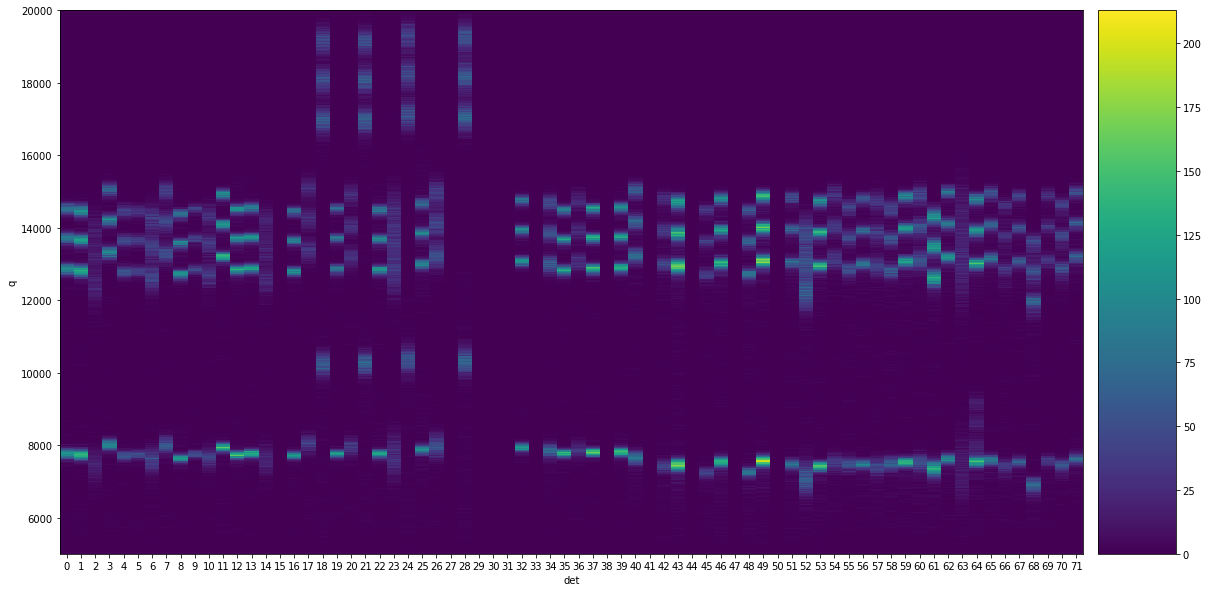

In [42]:
with open("data/calibration-heatmap.pickle", "rb") as f:
    calibration_heatmap = pickle.load(f)

fig_heatmap = plt.figure(figsize=(20, 10))
ax = fig.gca()
calibration_heatmap.plot2d(ax=ax);

:::{eval:figure} fig_heatmap
---
name: calibration-spectra
alt: A 2D histogram plotting the charge spectra distribution for each silicon detector. The x axis shows the detector number, whilst the y axis presents a heatmap of the 
width: 1000px
align: center
---
A 2D histogram of the charge distribution measured by each silicon detector for a fixed calibration source containing <sup>241</sup>Am, <sup>148</sup>Gd, <sup>239</sup>Pu, and <sup>244</sup>Cm.

For each detector, the charge distribution was fit as a sum of four Gaussians. In order to determine the set of initial fit parameters, a cumulative mass lookup was used to estimate the peak loci (see {numref}`calibration-charge-cmf`), and sensible values chosen for the peak width and scaling factor. 

In [13]:
calibration = ak.Array(
    [
        [[5442.80, 13.1], [5485.56, 84.8]],  # am
        [[5762.64, 23.10], [5804.77, 76.90]],  # cm
        [[5105.5, 11.94], [5144.3, 17.11], [5156.59, 70.77]],  # pu
        [[3182.690, 100]],  # gd
    ]
)

energy = calibration[..., 0]
weight = calibration[..., 1]

energy = np.sort(np.sum(energy * weight, axis=1) / np.sum(weight, axis=1))

/tmp/ipykernel_1616571/1611050797.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(t, z, "r", label="CMF", color="C1")


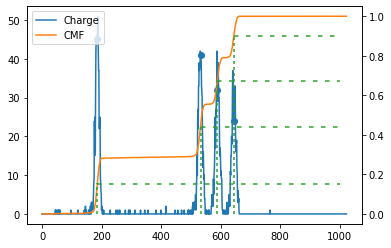

In [52]:
y = calibration_heatmap.values()[5]

z = np.cumsum(y)
z = z / z[-1]

t = np.arange(y.size)

x = np.r_[0.15, 0.44, 0.67, 0.9]
i_x = np.searchsorted(z, x)

fig_cmf, ax = plt.subplots()
ax2 = ax.twinx()

ax.scatter(t[i_x], y[i_x], label="Peak", color="C0")
lines = (
    ax.plot(t, y, label="Charge", color="C0") +
    ax2.plot(t, z, "r", label="CMF", color="C1")
)
ax2.hlines(x, t[i_x], 1000, linestyle=(0, (3, 5)), color="C2")
ax2.vlines(t[i_x], 0, z[i_x], linestyle=(0, (2, 2)), color="C2")
plt.legend(handles=lines)

:::{eval:figure} fig_cmf
---
name: calibration-charge-cmf
alt: A plot which overlays the cumulative mass fraction in red over a charge distribution histogram in blue. The loci of the peaks in the histogram are found at particular mass fractions, which are indicated with horizontal dashed green lines.
width: 400px
align: center
---
The charge distribution for a random silicon detector, superimposed with a plot of the cumulative distribution. The dashed lines indicate particular fractions of the cumulative distribution at which the peaks are localised.
:::

This method of localising the decay peaks from the calibration source is robust in the face of varying detector noise. Following the peak fitting process, a linear regression was then performed against the known energies given in {numref}`calibration-sources` to obtain a set of calibration coefficients for each detector. A superposition of the calibrated charge distributions can be seen in {numref}`calibrated-distributions`.

:::{figure} image/placeholder/calibrated-distributions.png
---
name: calibrated-distributions
alt: A plot which overlays the calibrated charge distributions for all of the silicon detectors. The characteristic decay peaks are all aligned about the appropriate energy value. Some distributions include additional peaks.
width: 400px
align: center
---
A combined plot of the calibrated charge distribution histograms.
:::

Whilst the majority of detectors exhibited a resolution of 70-120 keV at 3182.7 keV, it can be seen that there are some detectors with degraded resolution. The waveforms measured by these detectors were subsequently discarded.

:::{warning}
Is this resolution too poor given [^1]?
> (...) only one of 12 has lost the resolution below an acceptable level (75 keV).
:::

[^1]: https://www.sciencedirect.com/science/article/pii/S0168900220300073

## Garfield++ Simulation

## Cluster Reconstruction

## Track Fitting

## Kinematic Fitting

## Beam